# **Instituto Tecnológico de Monterrey**

**Maestría en Inteligencia Artificial Aplicada**

Avance 4.- Modelos alternativos

Integrantes:

- Nancy Elena Estanislao Lizárraga - A01169334

- Héctor Raúl Vázquez González - A00565542

- Gustavo Rene Ramos Ojeda - A01793599

# **Preprocesamiento de Información**

Importación de Librerías

In [182]:
#Obtención de Datos
import pandas as pd
#Escalamiento
from sklearn.preprocessing import MinMaxScaler
import numpy as np
#Análisis de Características
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

#Modelos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score

**Obtención de Datos**

Se obtiene la información desde un sitio en internet, se guarda en un Dataframe.
Por ultimo, se eliminan los datos nulos

In [183]:
#Path del archivo CSV con la información con la que vamos a Trabajar
FilePath = 'https://raw.githubusercontent.com/gusrro/ProyectoIntegrador/main/dataF.csv'
#Creación del Dataframe usando el path del archivo
df_original = pd.read_csv(FilePath)

In [184]:
#Creamos una copia del dataframe original
#A partir de este punto se trabajará con esta copia
df_notnull = df_original.copy()
#Eliminamos las filas que contengan espacios nulos
df_notnull.dropna( axis=0, inplace=True)

**Análisis de la información**

Se observan las columnas en la información obtenida

In [185]:
df_analisis = df_notnull.copy()
df_analisis.columns

Index(['day', 'mont', 'year', 'credited', 'debited', 'type', 'week_day',
       'perc_remain'],
      dtype='object')

In [186]:
df_analisis.describe()

,day,mont,year,credited,debited,week_day,perc_remain
count,968.000000,968.000000,968.000000,9.680000e+02,9.680000e+02,968.000000,968.000000
mean,15.603306,6.632231,2021.341942,8.817488e+06,6.807160e+06,3.876033,75.134654
std,8.817327,3.539272,0.847050,5.588481e+06,4.563191e+06,1.961660,2321.471128
min,1.000000,1.000000,2020.000000,2.882250e+00,-3.565154e+05,1.000000,0.120655
25%,8.000000,3.000000,2021.000000,3.641171e+06,2.145982e+06,2.000000,0.204447
50%,16.000000,7.000000,2021.000000,1.013495e+07,7.884900e+06,4.000000,0.229106
75%,23.000000,10.000000,2022.000000,1.260134e+07,1.001369e+07,6.000000,0.420389
max,31.000000,12.000000,2023.000000,3.456432e+07,2.569507e+07,7.000000,72227.748430


In [187]:
df_analisis.dtypes

day              int64
mont             int64
year             int64
credited       float64
debited        float64
type            object
week_day         int64
perc_remain    float64
dtype: object

El Set de información contiene 968 registros con 8 columnas. Las columnas que se pueden obervar son:

- **day**.- Esta Columna contiene los datos de qué día del mes es el registro. La información es de enteros en el rango de 1 a 31.
- **mont**.-Esta Columna contiene los datos de qué mes es el registro. La información es de enteros en el rango de 1 a 12.
- **year**.-Esta Columna contiene los datos de qué año es el registro. La información es de enteros en el rango de 2020 a 2023.
- **credited**.-Esta columna contiene el dato del monto que la institución depositó en su cuente de Banjico el día especificado por las otras columnas.
- **debited**.- Esta columna contiene el dato del monto que la institución utlizó en su cuente de Banjico el día especificado por las otras columnas.
- **type**.- En esta columna se especifica como se considera la fecha especificada en las otras columnas. La información que contiene esta columna se reduce a un caracter; 'N' para día nomrmal y 'P' para día festivo.
- **week_day**.- Esta Columna contiene los datos de qué día de la semana es la fecha indicada por las demás columnas. La información es de enteros en el rango de 1 a 7.
- **perc_remain**.-Esta Columna contiene los datos del porcentaje del monto que quedó sin utilizar en la fecha indicada por las demás columnas.

Actualmente se puede trabajar con todas las columnas, excepto con la columna de "type" ya que al ser de tipo "objeto" limita mucho las herramientas que se pueden utilizar. Lo que se puede hacer para mejorar este escenario, sin perder nada de informacíón, es cambiar las "N" por "0" y las "P" por "1". De esta forma podemos utilizar esta columna cono entero o boleano, según nos convenga.

In [188]:
#Se defina la función para cambiar el tipo de dato de la columna "type"
def change_typeColumn(df):
  df['type'] = df['type'].map({'N': False, 'P': True})
  return df

In [189]:
#Se procesa el cambio
df_analisis = change_typeColumn(df_analisis)

In [190]:
#Visualizamos los cambios
df_analisis.dtypes

day              int64
mont             int64
year             int64
credited       float64
debited        float64
type              bool
week_day         int64
perc_remain    float64
dtype: object

Ya que el objetivo del proyecto será "predecir en lo mayor posible cuanto gastará la institución en un particular día" podemos volcar nuestra atención en la columna "debited".

Visualicemos como se encuentra la información:

In [191]:
#Se establece el tamaño de la gráfica
sns.set( rc= {'figure.figsize':(15, 10)})

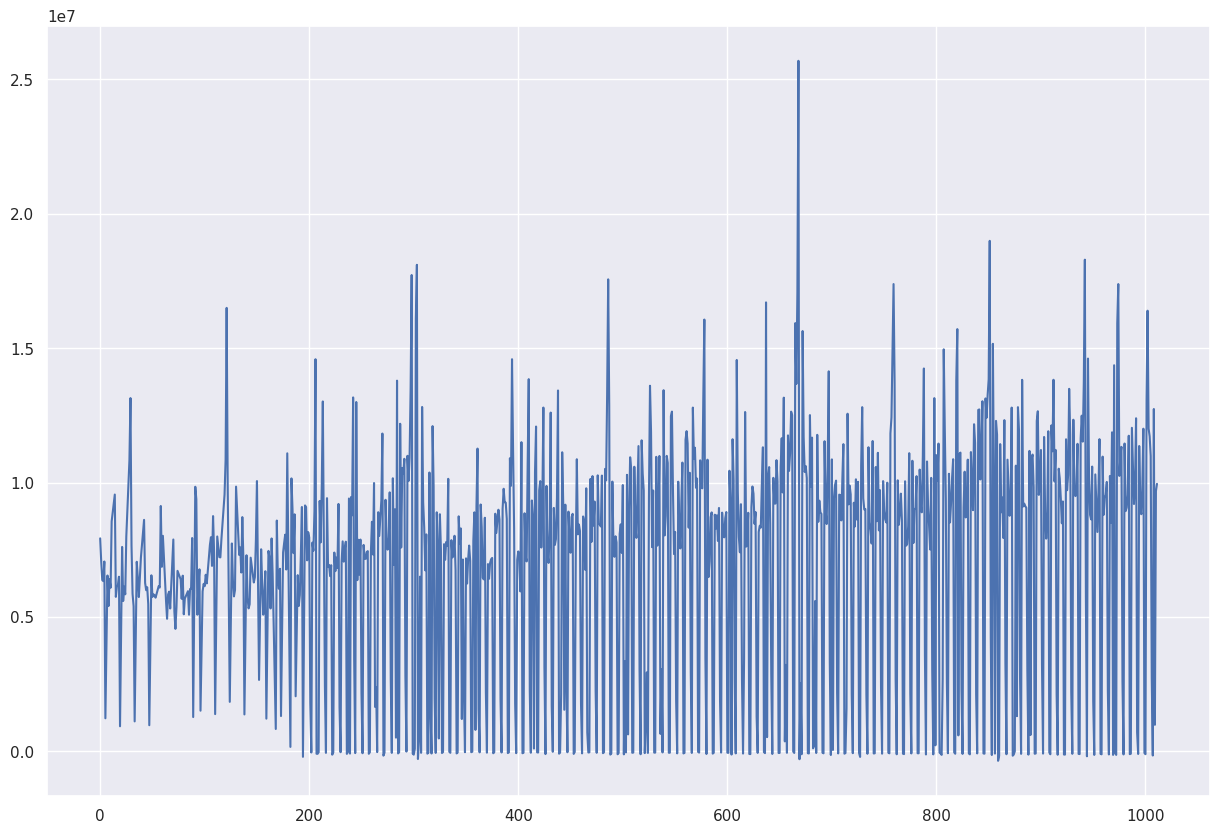

In [192]:
#Se grafica la información
df_grafica = df_analisis.copy()
plt.plot(df_grafica["debited"])
plt.show()

Podemos observar que existen outliers en la parte superior y en la parte inferior de la tendencia. Estos outliers podrían introducir ruido en el proceso de aprendizaje de nuestros modelos.

Vamos a separar en dataframe diferentes los outliers para estudiarlos por separados.

In [193]:
#Se declaran los dataframe que se utilizarán
df_min_noise = []
df_max_noise = []
df_noiseless = []

Ahora, estudiariaremos el ruido en la parte inferior de la gráfica. Según la gráfica original, podemos considerar todos los valores por debajo de "5,000,000" como outliers.

Separaremos estos outliers para analizarlos.

In [194]:
df_min_noise = df_analisis[df_analisis["debited"] <= 5000000]
df_min_noise

,day,mont,year,credited,debited,type,week_day,perc_remain
5,6,6,2020,2.657577e+06,1.226194e+06,False,6,0.538604
19,20,6,2020,1.976021e+06,9.289228e+05,False,6,0.529902
33,4,7,2020,2.272686e+06,1.110432e+06,False,6,0.511401
47,18,7,2020,1.926166e+06,9.676823e+05,False,6,0.497612
64,4,8,2020,6.797847e+06,4.929447e+06,False,2,0.274852
...,...,...,...,...,...,...,...,...
999,25,2,2023,5.077502e+05,-6.525402e+04,False,6,1.128516
1000,26,2,2023,1.486699e+05,-1.101872e+05,False,7,1.741153
1006,4,3,2023,4.876290e+06,2.727221e+06,False,6,0.440718
1007,5,3,2023,1.842645e+05,-1.593418e+05,False,7,1.864745


Como podemos ver, las fechas indicadas en estos outliers corresponden a sábados y Domingos; son días que la institución no trabaja, y por tanto el modelo no será consultado para dichas fechas.

Hemos platicado con el contacto de la institución y nos ha dicho que sería mejor no tomar en cuante esta información. A continuación, haremos una función para eliminar los outliers que estén por debajo de este parámetro.

In [195]:
#Se define una función para eliminar los registros con valores en la columna de debited menores a 5,000,000
def remove_min_noise(df, column):
  df_temp = df.copy()
  for row in df.index:
    if df_temp[column][row] <= 5000000:
      #df_min_result.append(df.loc[row])
      df_temp.drop(row, axis=0, inplace=True)
  return df_temp

In [196]:
#se procesa el cambio
df_noiseless = remove_min_noise(df_analisis,"debited")

Ahora haremos el mismo procedimiento para los outliers mayores a "14,000,000" para analizar la naturaleza de este comportamiento.

In [197]:
df_max_noise = df_analisis[df_analisis["debited"] >= 14000000]
df_max_noise

,day,mont,year,credited,debited,type,week_day,perc_remain
121,30,9,2020,20893465.98,16499443.11,True,3,0.210306
206,24,12,2020,17836044.89,14588777.87,False,4,0.182062
298,26,3,2021,21540714.89,17723167.07,False,5,0.177225
302,30,3,2021,20852684.73,16085938.48,False,2,0.228591
303,31,3,2021,25320180.83,18102150.25,True,3,0.285070
394,30,6,2021,18592805.89,14588968.01,True,3,0.215343
486,30,9,2021,22354026.96,17561510.66,True,4,0.214392
578,31,12,2021,20812357.75,16064711.09,True,5,0.228117
609,31,1,2022,19501478.36,14561190.75,True,1,0.253329
637,28,2,2022,22082296.02,16704190.05,True,1,0.243548


Esta información corresponde a fechas de días festivos, o bien, fechas aledañas a días festivos. Por ejemplo, el 24 de Diciembre que no es propiamente un día festivo, sin embargo el 25 lo es. Esto hace que los movimientos del día 24 sean mayores.

Este es un comprortamiento esperado y natural del negocio, por tanto, sería un error eliminar este información. Sin embargo, existe un movimiento atípico en esta información:

In [198]:
df_atipico = df_analisis[df_analisis["debited"] >= 20000000]
df_atipico

,day,mont,year,credited,debited,type,week_day,perc_remain
668,31,3,2022,34564319.43,25695066.21,True,4,0.256601


En los tres años de información que se tiene, no se rebasa el límite de 13 millones por día en movimientos; pero en este día se movieron 25 millones.

Cuando vemos que la institución se preparó para este movimiento, acreditando un 25% más de los 25 millones ese día. Podemos inferir que esta información no es erronea y que la institución estaba prevenida para esto, sin embargo, es una situación especial.

Después de comentarlo con nuestro contacto de la institución, llegamos al acuerdo de que podemos tomar el mismo día del año anterior y del año posterior y haer un promedio para darle un valor más cercano al esperado ese día, y de esta forma reducir el ruido para nuestro modelo.

In [199]:
#se obtienen las cantidades de los días en cuestión
df_diaAnterior_tipico = df_analisis[df_analisis["year"] == 2022]
df_diaAnterior_tipico = df_diaAnterior_tipico[df_diaAnterior_tipico["mont"] == 5]
df_diaAnterior_tipico = df_diaAnterior_tipico[df_diaAnterior_tipico["day"] == 31]
df_diaAnterior_tipico

,day,mont,year,credited,debited,type,week_day,perc_remain
729,31,5,2022,17079547.56,12805472.2,True,2,0.250245


In [200]:
df_diaPosterior_tipico = df_analisis[df_analisis["mont"] == 10]
df_diaPosterior_tipico = df_diaPosterior_tipico[df_diaPosterior_tipico["year"] == 2022]
df_diaPosterior_tipico = df_diaPosterior_tipico[df_diaPosterior_tipico["day"] == 31]
df_diaPosterior_tipico

,day,mont,year,credited,debited,type,week_day,perc_remain
882,31,10,2022,18511815.0,13821696.96,True,1,0.253358


Ahora, con las cantidades de 12,805,472.2	y 13,821,696.96 podemos hacer el promedio para nuestro valor típico.

In [201]:
#Se define la función que cambiará el valor en la fecha designada
def correct_value_onday(day,mont,year,value,df):
  for row in df.index:
    if df["year"][row] == year:
      if df["mont"][row] == mont:
        if df["day"][row] == day:
          df["debited"][row] = value
          break
  return df

In [202]:
#se procesa el cambio
df_noiseless = correct_value_onday(31,3,2022,((12805472.2 + 13821696.96)/2), df_noiseless)

<ipython-input-201-f8dab5b5aa87>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["debited"][row] = value


In [203]:
#Checamos el resultado
df_atipico = df_noiseless[df_noiseless["day"] == 31]
df_atipico = df_atipico[df_atipico["mont"] == 3]
df_atipico = df_atipico[df_atipico["year"] == 2022]
df_atipico

,day,mont,year,credited,debited,type,week_day,perc_remain
668,31,3,2022,34564319.43,13313584.58,True,4,0.256601


Ahora, el valor atípico ha sido cambiado. Vamos a visualizar como ha terminado nuestra gráfica

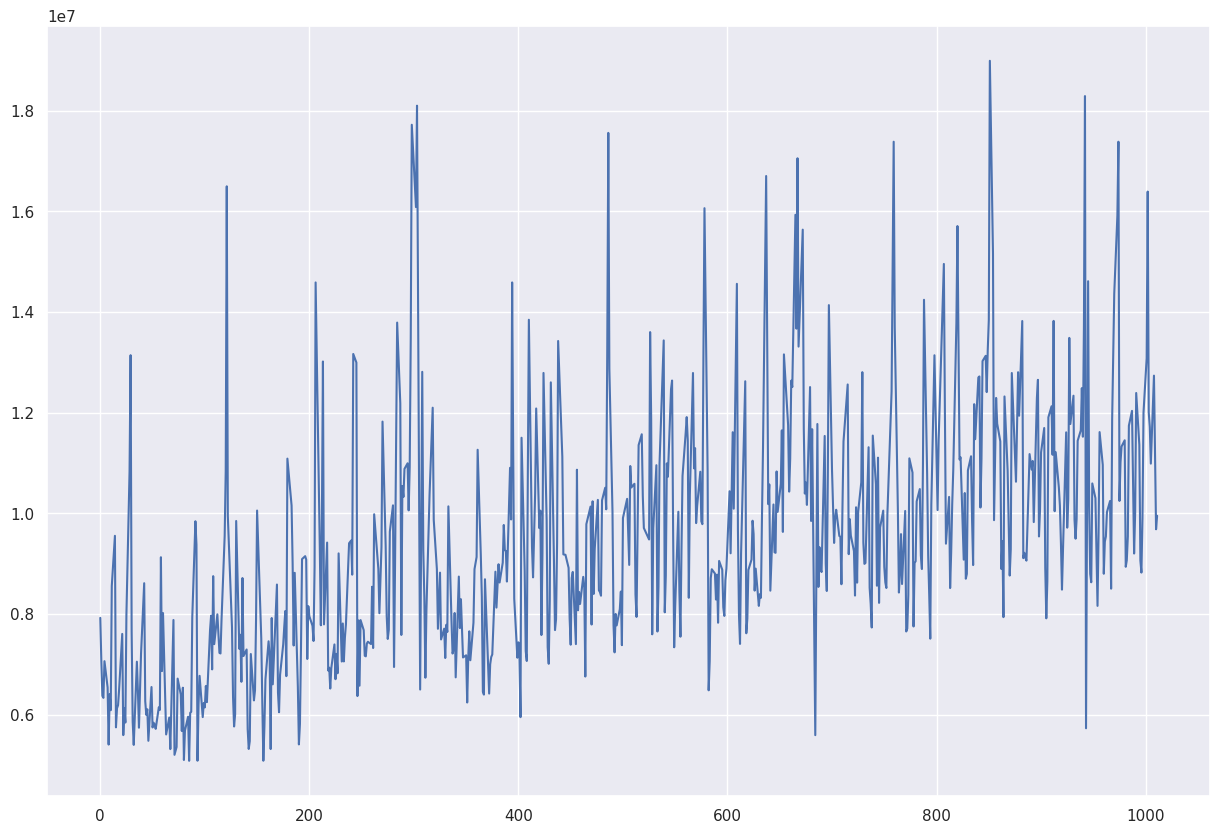

In [204]:
plt.plot(df_noiseless["debited"])
plt.show()

Podemos observar una tendencia mucho más clara que la original.

**Transformación**

Ahora veamos la distribución de la columna "debited".

In [205]:
#se crea un copia para trabajar la transformación
df_transformado = df_noiseless.copy()

<Axes: >

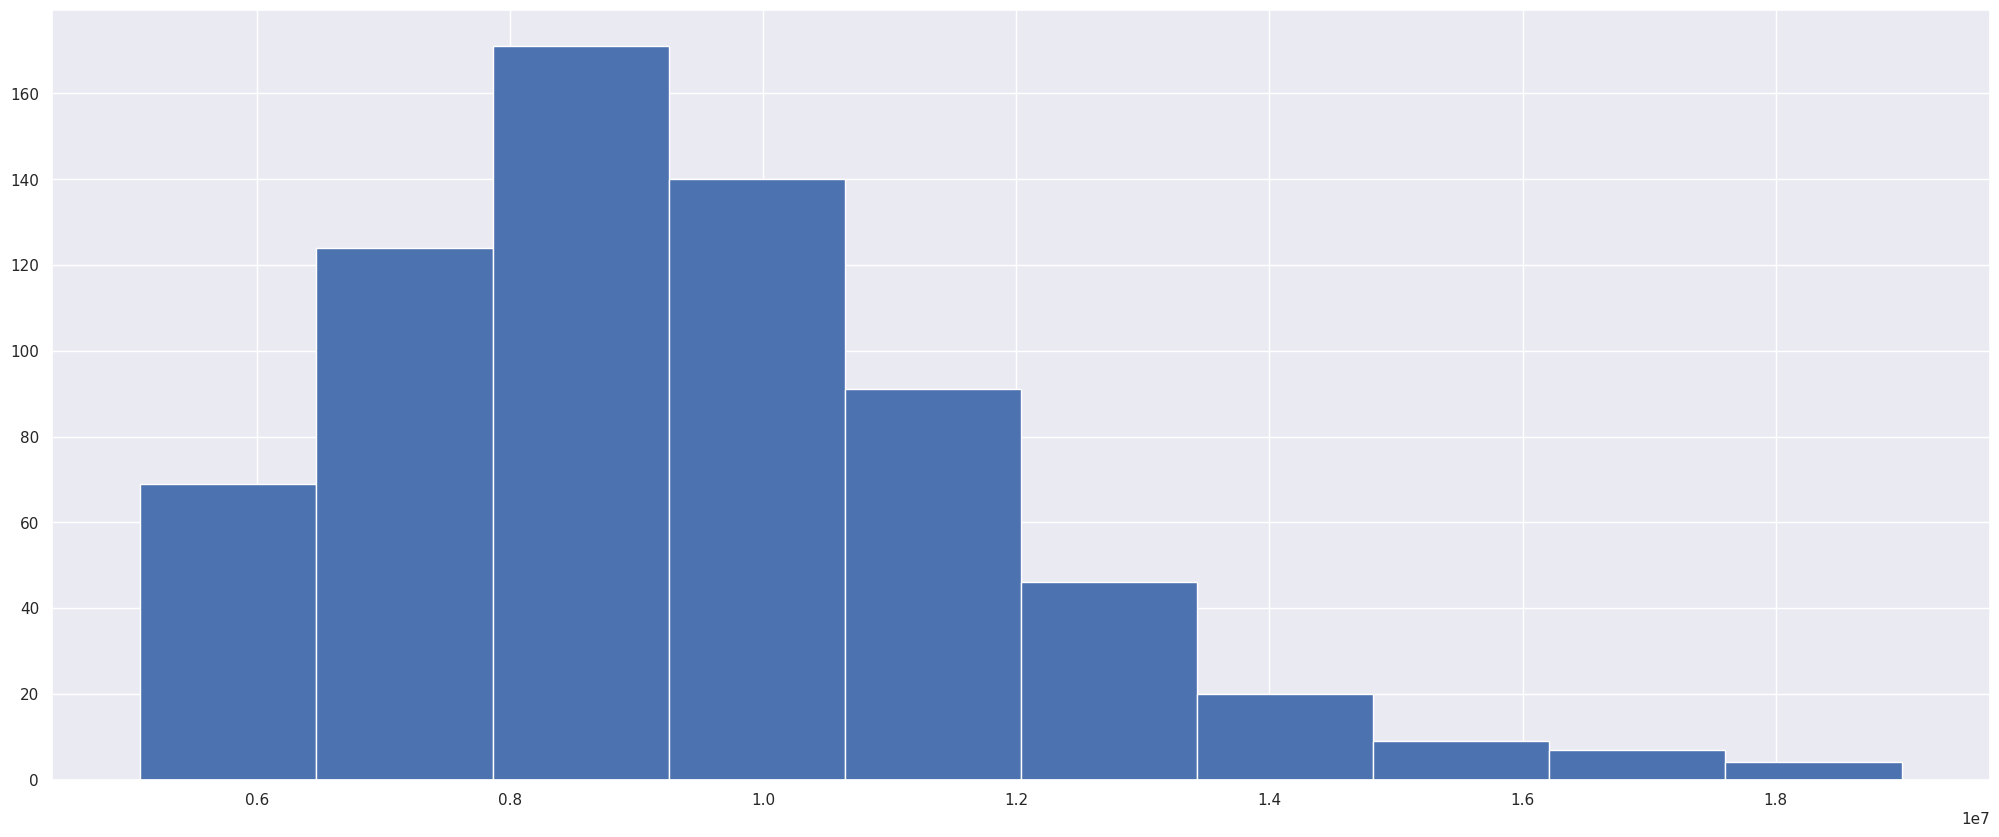

In [206]:
df_transformado["debited"].hist( bins=10 ,figsize=(25,10))

La distribución no está tan mal, tiene una buena forma. Sin embargo, vamos a invbestigar si algún tranformador puede mejorar la distribución normal de estos valores.

In [207]:
#Se define las columnas que serán tratadas
columns_to_scale = ['debited']

Así que intentaremos con Z-score (Standard Scaler)

array([[<Axes: title={'center': 'debited'}>]], dtype=object)

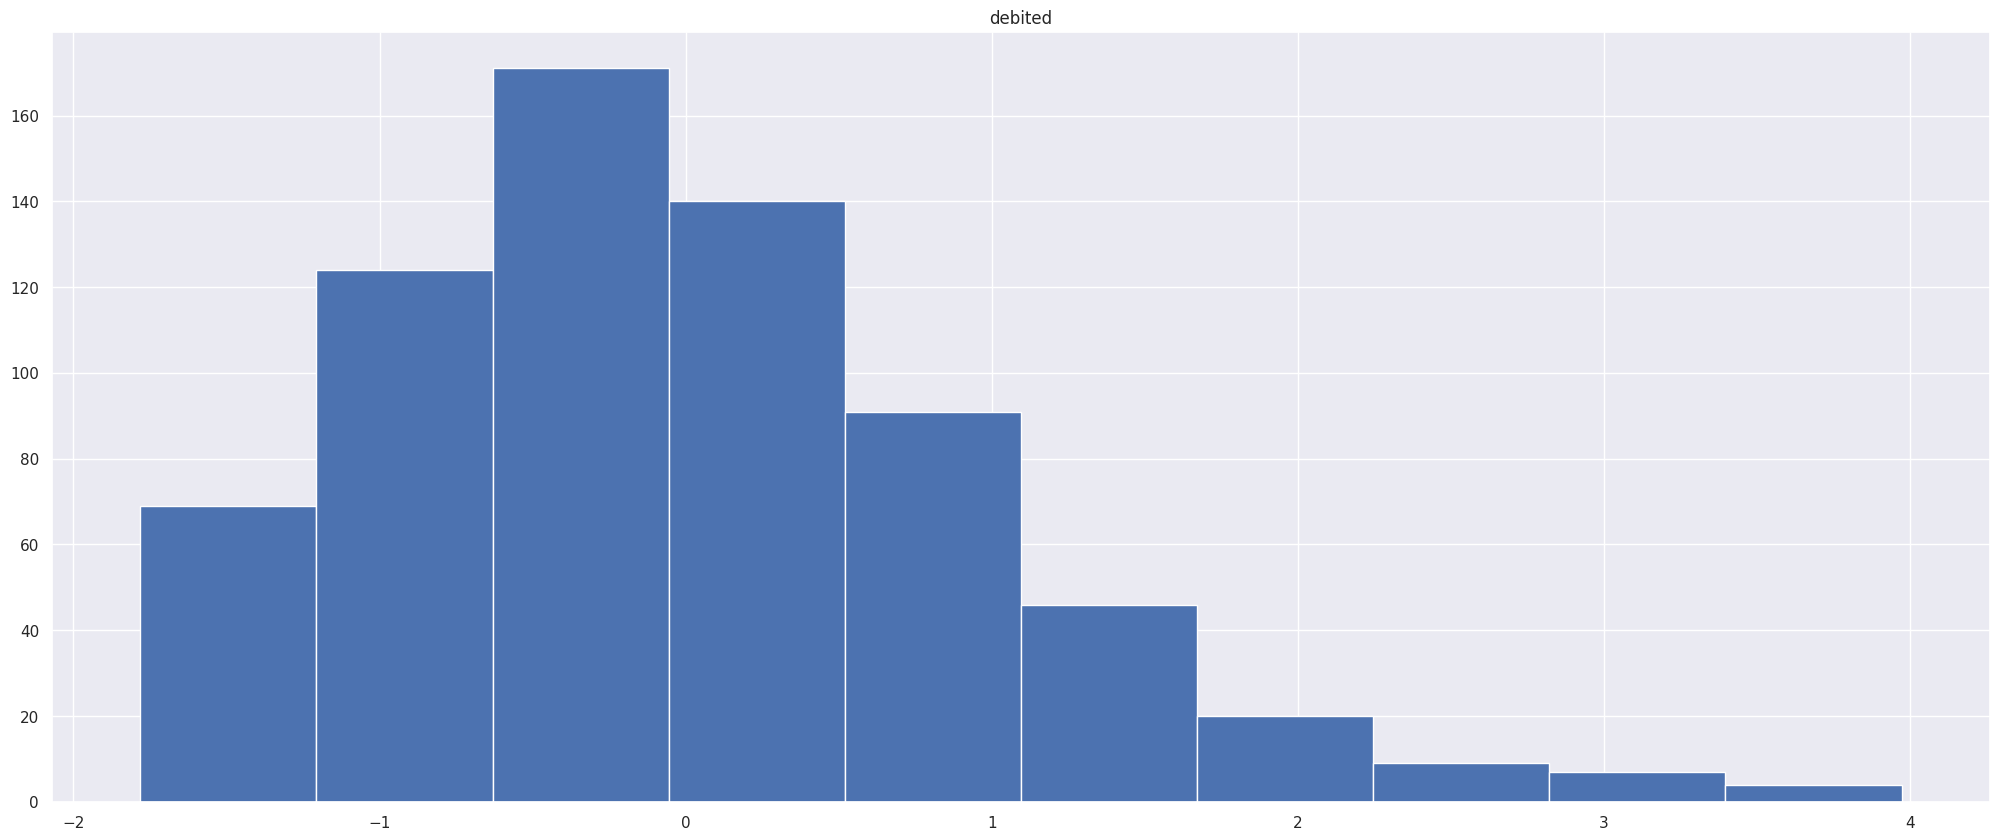

In [208]:
#Se crea el objeto transformador
z_score_scaler = StandardScaler()
#Se aplica la operación de Z-score
df_transformado[columns_to_scale] = z_score_scaler.fit_transform(df_transformado[columns_to_scale])
#Y verificaremos que la información tenga una mejor distribución
df_transformado[columns_to_scale].hist( bins=10 ,figsize=(25,10))

StandardScaler tiene muy poco efecto en la distrtibución, aun que movió los valores en el eje X para que se adapte mejor a la distribución normal.

Ahora intenrtaremos Raíz cuadrada.

array([[<Axes: title={'center': 'debited'}>]], dtype=object)

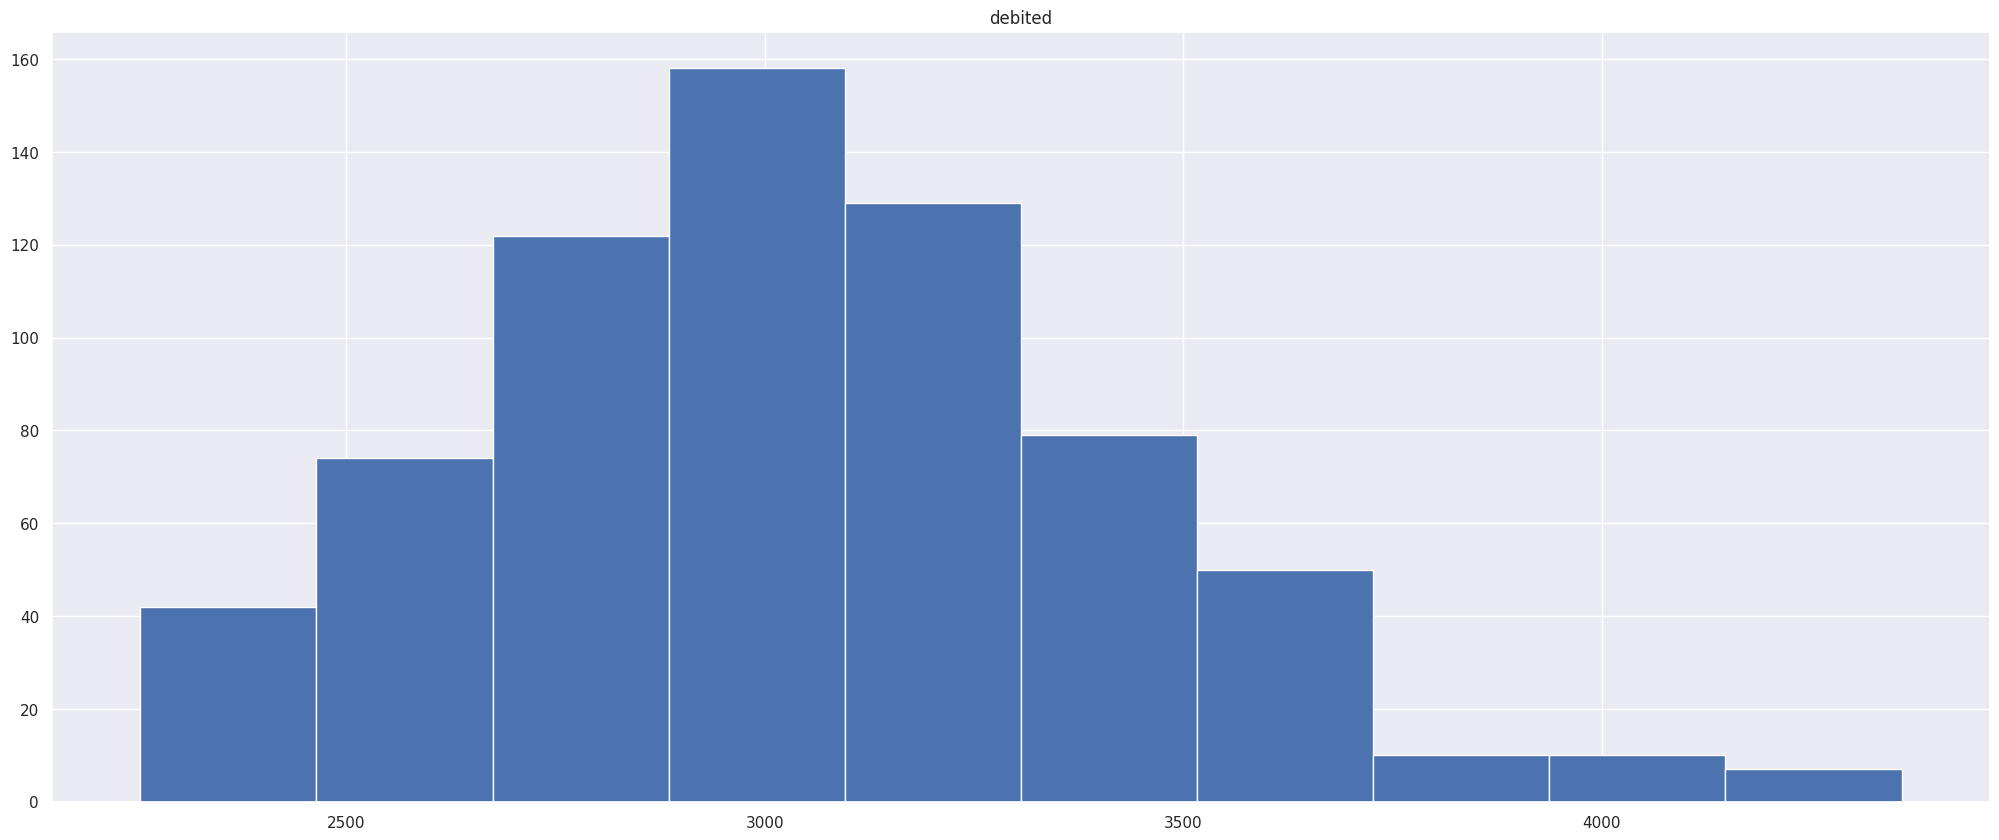

In [209]:
#se crea un copia para trabajar la transformación
df_transformado = df_noiseless.copy()
# Transformación de raíz cuadrada para las columnas seleccionadas
df_transformado[columns_to_scale] = np.sqrt(df_transformado[columns_to_scale])
#Ahora, revisaremos el resultado de la operación.
#Y verificaremos que la información tenga una mejor distribución
df_transformado[columns_to_scale].hist( bins=10 ,figsize=(25,10))

Aunque los valores se movieron en el eje X, podemos obserbar que la distribución de los datos ha mejorado.

Pasaremos ahora por el StandardScaler para ver si podemos mejorar la posición en el eje X de los valores actuales

array([[<Axes: title={'center': 'debited'}>]], dtype=object)

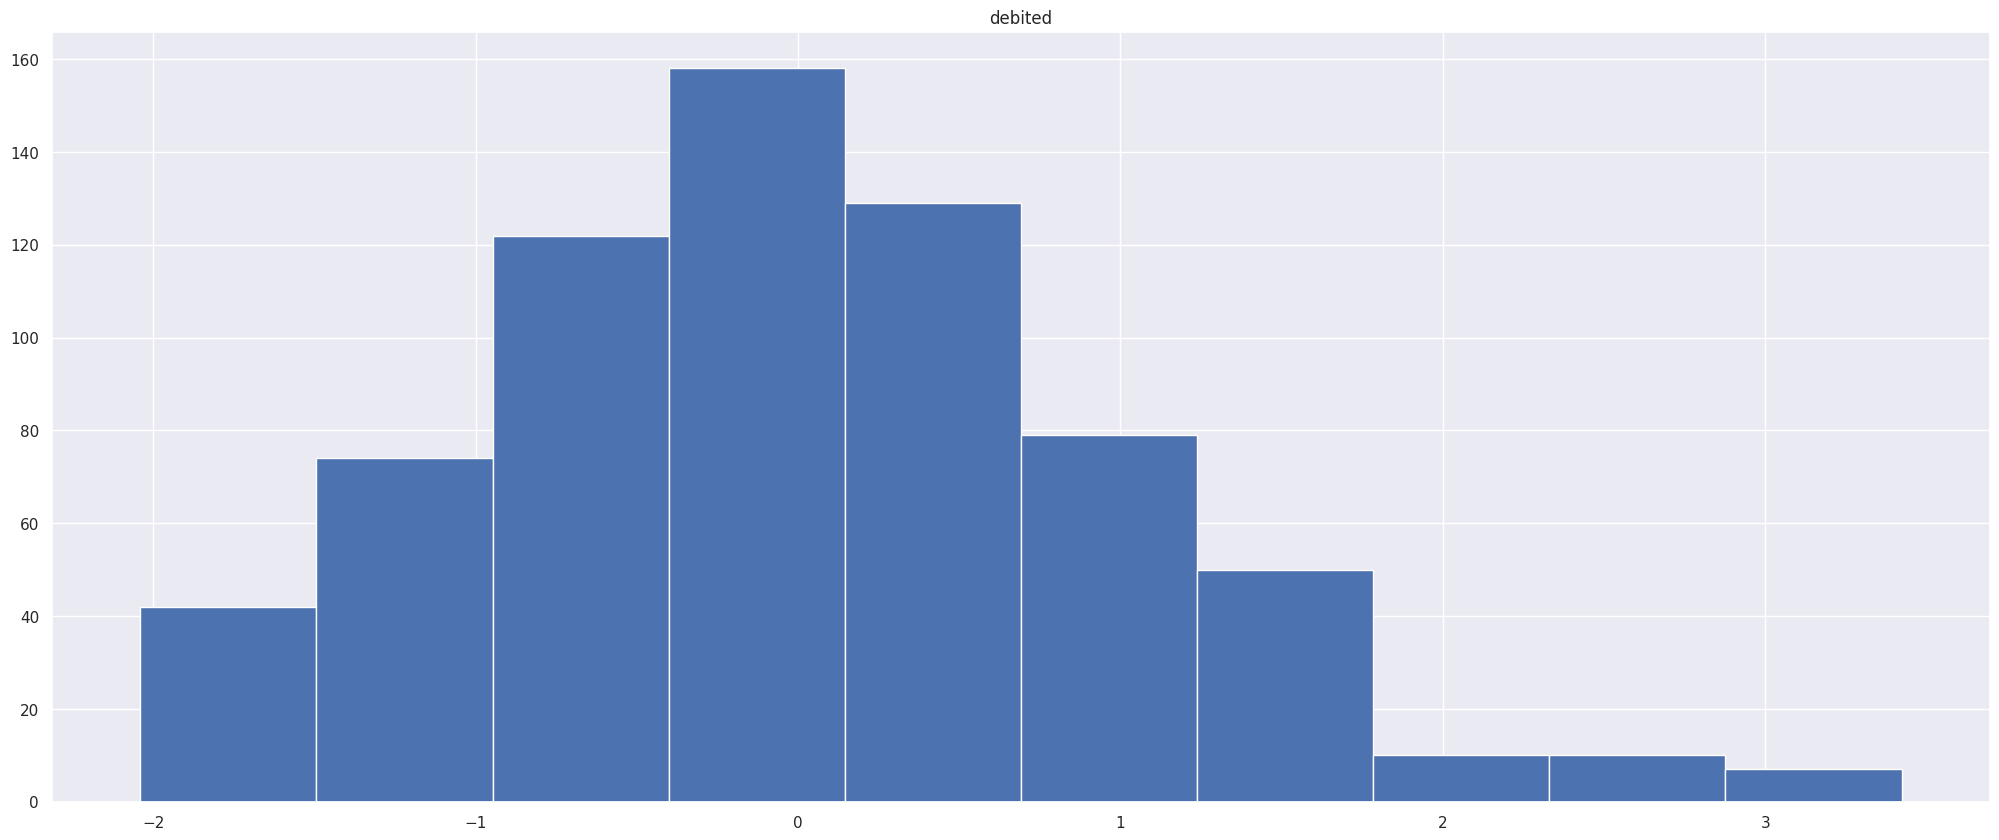

In [210]:
#Se aplica la operación de Z-score
df_transformado[columns_to_scale] = z_score_scaler.fit_transform(df_transformado[columns_to_scale])
#Y verificaremos que la información tenga una mejor distribución
df_transformado[columns_to_scale].hist( bins=10 ,figsize=(25,10))

Y nos quedaremos con el resultado de esta técnica combinada para los valores procesados.

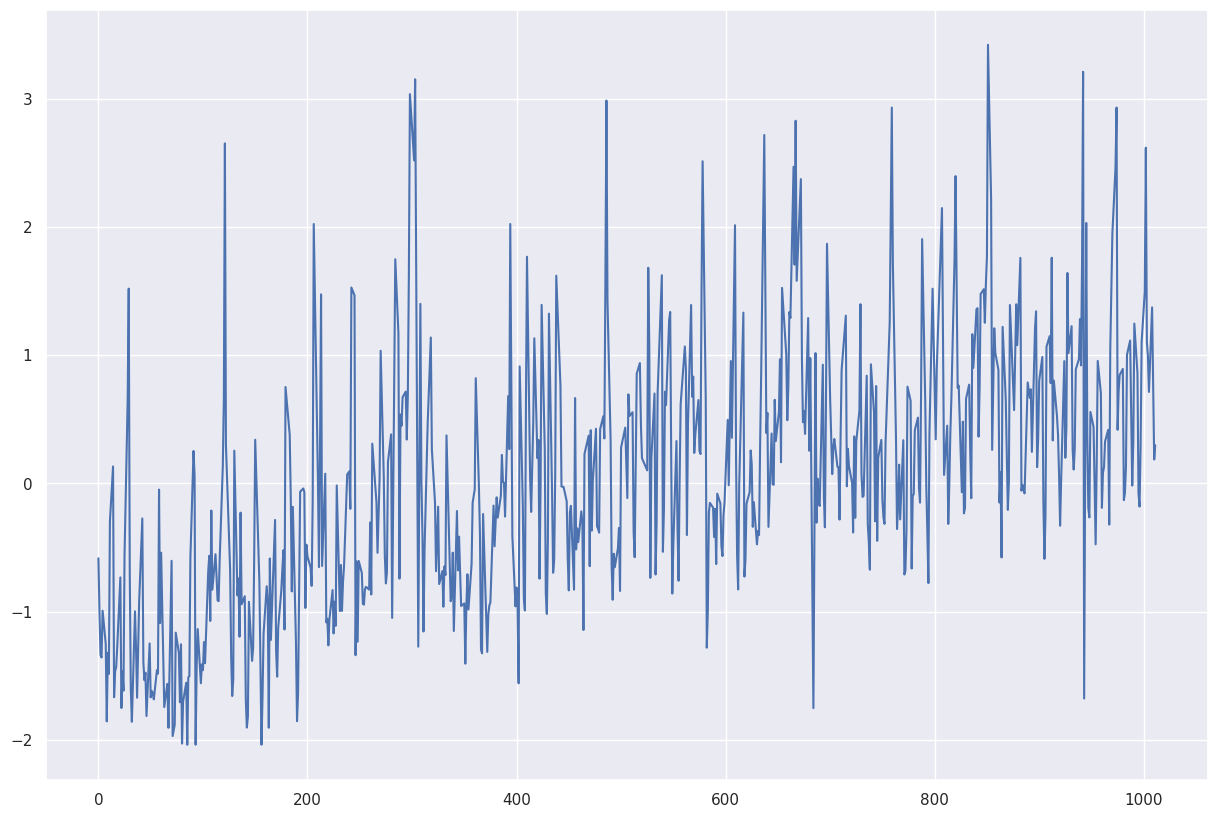

In [211]:
plt.plot(df_transformado["debited"])
plt.show()

Ahora, vamos a checar los valores de correlación que existen entre las columnas

In [212]:
#Vamos a ver la correlación con la nueva información
#Se obtiene la matriz de correlación del Dataframe con el que se está trabajando
#(Se ha organizado conforme a la correlación con la columna debited)
MatrizDeCorrelación = df_transformado[['debited','credited','year','perc_remain','day','type','mont','week_day']].corr()

<Axes: >

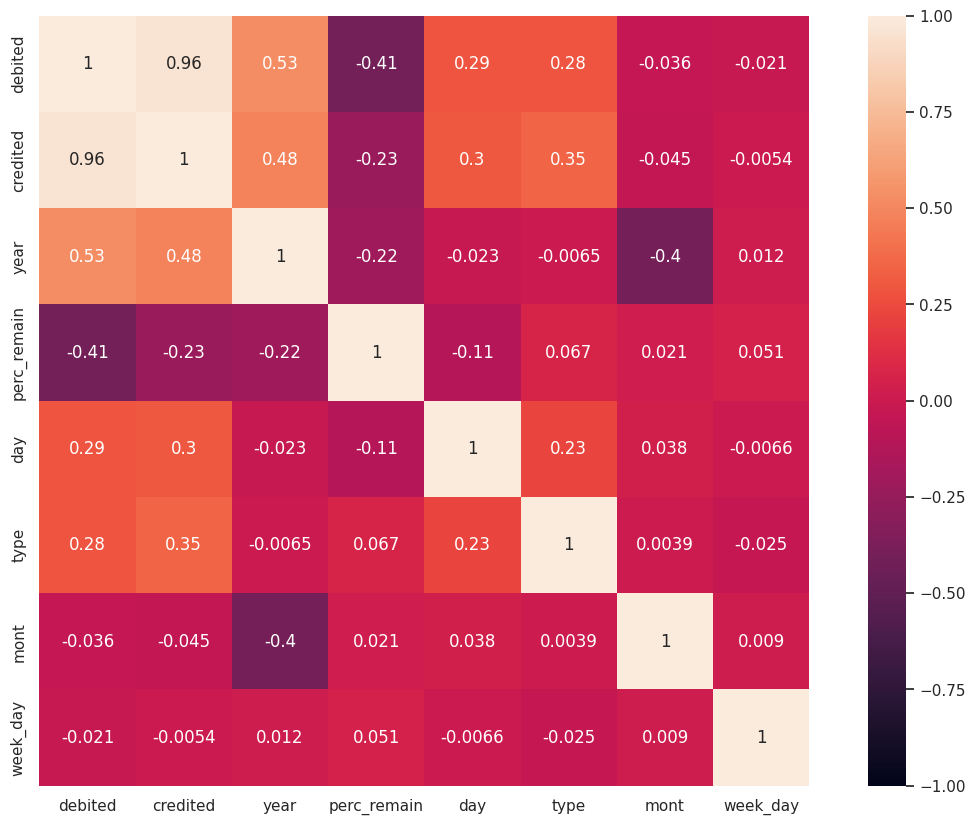

In [213]:
sns.heatmap( MatrizDeCorrelación, vmin = -1, vmax = 1, square=True, annot = True)

Ya con la información de manera visual, podemos avanzar a la eliminación de características que se consideran que no deben/pueden ser admitidas como variables de entrada.

Características que se generaron en el futuro; las siguientes características se generaron cuando el día se terminó y por tanto, no pueden ser una entrada en nuestro modelo (se supone que será consultado al principio del día).
- **Credited**.- Se refiere al monto que se depositó durante el día.
- **perc_remain**.- Se refiere al porcentaje del monto que no se utilizó durante el día.

In [214]:
#Se crea una copia del Dataframe para seguir trabajando
df_limpio = df_transformado.copy()

In [215]:
df_limpio.drop(['credited','perc_remain'], axis=1, inplace=True)

# **Modelos**

En esta sección se analizarán los modelos propuestos para lograr predecir la tendencia de nuesto set de datos.

In [216]:
#Se hace una copia del dataframe para trabajar con los modelos
df_modelos = df_limpio.copy()
df_modelos.shape

(681, 6)

Primero crearemos los set de datos para X y Y, y en seguida se separarán los datos en grupos para entrenamiento,prueba y evaluación (train,test y val)

In [217]:
#Dividiremos en X y Y
X = df_modelos[['day', 'mont', 'year', 'type', 'week_day']].copy()
Y = df_modelos['debited'].copy()

In [218]:
#Ahora separaremos en los grupos antes mencionados
X_train, X_test, y_train, y_test = train_test_split( X , Y , test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [219]:
#Por último, checaremos las proporciones
print("Tamaño de X_train: ", str(len(X_train)), " - ", round((len(X_train)*100)/len(df_modelos),2),"%")
print("Tamaño de X_test: "+ str(len(X_test)), " - ", round((len(X_test)*100)/len(df_modelos),2),"%")
print("Tamaño de X_val: "+ str(len(X_val)), " - ", round((len(X_val)*100)/len(df_modelos),2),"%")
print("**********************************")
print("Tamaño de y_train: "+ str(len(y_train)))
print("Tamaño de y_test: "+ str(len(y_test)))
print("Tamaño de y_val: "+ str(len(y_val)))

Tamaño de X_train:  408  -  59.91 %
Tamaño de X_test: 137  -  20.12 %
Tamaño de X_val: 136  -  19.97 %
**********************************
Tamaño de y_train: 408
Tamaño de y_test: 137
Tamaño de y_val: 136


**Los Modelos a utlizar**

Ahora, creamos una función que contenga los modelos con los que vamos a probar. Lo haremos de esta forma en caso de que más adelante se decida agregar más modelos a este proceso.

El modelo que se utilizará es el de Regresion logística, Lasso, Ridge y Elastic Net, todos los modelos estarán con sus características por defecto.

In [220]:
def get_models():
  modelos = list()
  nombres = list()
  alpha_value = .0001

  # LR - Regresión Logística:
  modelos.append(LinearRegression())
  nombres.append('LR')

  modelos.append((Lasso(alpha=alpha_value)))
  nombres.append('LASSO')

  modelos.append((Ridge(alpha=alpha_value)))
  nombres.append('RIDGE')

  modelos.append((ElasticNet(alpha=alpha_value, l1_ratio=.0005)))
  nombres.append('EN')

  return modelos, nombres

In [221]:
modelos, nombres = get_models()  # cargamos los modelos a comparar
resultados = list() #Creamos la liste para los resultados

Primero crearemos un pipeline para la transformación de las columnas numéricas. Los pasos serán:
- un imputador
- un escalador

Para el imputador utilizaremos "la mediana", mientras que el escalador será in Minmax en el rango de 1 a 2.

Después, declararemos un transformador de columnas con nuestro pipeline. Las columnas que se pasarán a travéz de este paso serán las declaradas como "columns_to_process"; el resto de las columnas pasarán sin cambios.

In [222]:
#Columnas a tratar
columns_to_process = ['day', 'mont', 'year', 'week_day']

# Transformaciones a factores numéricos de entrada:
num_pipeline = Pipeline(steps = [('impMediana', SimpleImputer(strategy='median')),
                                 ('escalaNum', MinMaxScaler(feature_range=(1,2)))])

# Conjuntamos las transformaciones numéricas y categóricas que se estarán aplicando a los datos de entrada:
columnasTransformer = ColumnTransformer(transformers = [('numpipe', num_pipeline, columns_to_process)],
                                        remainder='passthrough')

In [223]:
y_pred = []
for i in range(len(modelos)):

  pipeline = Pipeline(steps=[('ct',columnasTransformer),('m',modelos[i])])

  pipeline.fit(X_train, y_train)
  scores = pipeline.score(X_test,y_test)

  y_pred.append(pipeline.predict(X_test))


  resultados.append(scores)
  print('>> %s: %.3f ' % (nombres[i], np.mean(scores)))

>> LR: 0.501 
>> LASSO: 0.500 
>> RIDGE: 0.501 
>> EN: 0.500 


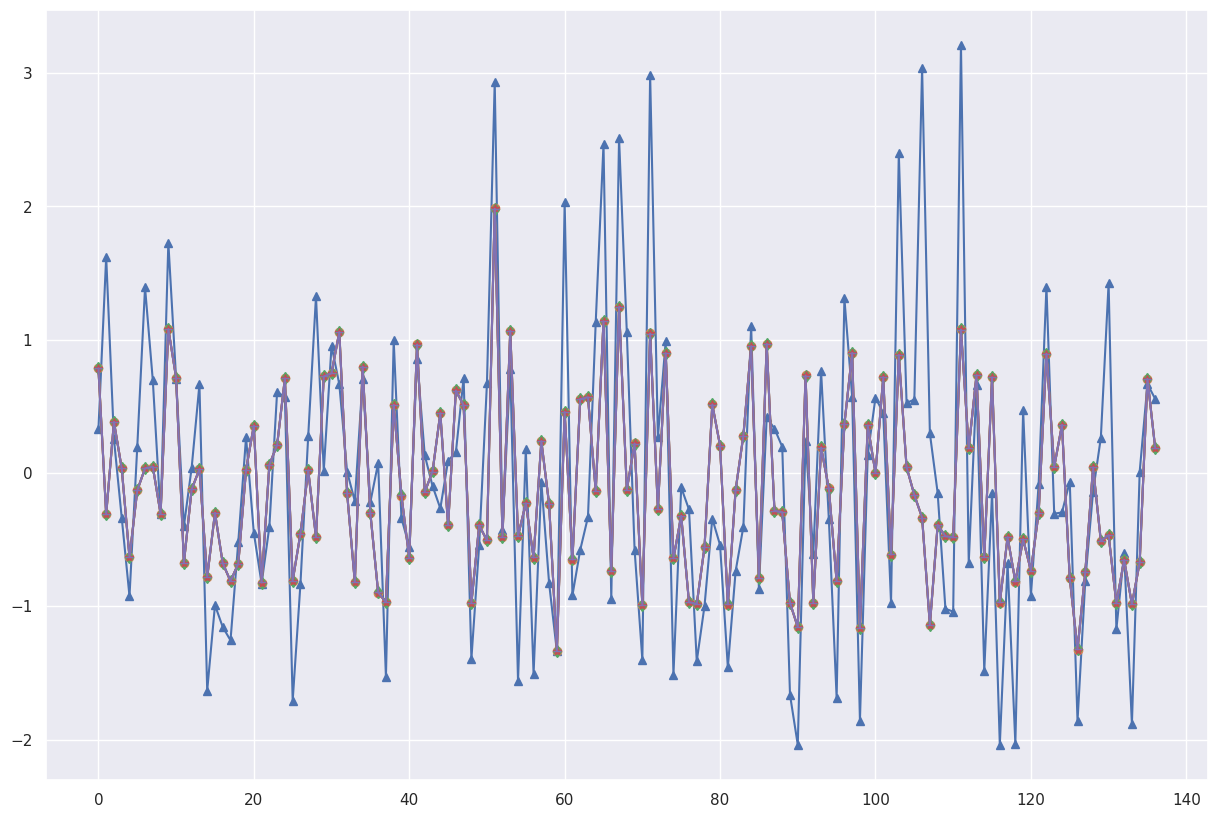

In [224]:
x1 = np.arange(0,len(y_test))

plt.plot(x1, np.ravel(y_test), marker='^', label='Test')
plt.plot(x1, np.ravel(y_pred[0]), marker='o', label='LR')
plt.plot(x1, np.ravel(y_pred[1]), marker='d', label='LASSO')
plt.plot(x1, np.ravel(y_pred[2]), marker='*', label='RIDGE')
plt.plot(x1, np.ravel(y_pred[3]), marker='_', label='EN')

Vemos una mejora en el rendimiento de los modelos solo con mejorar el preprocesamiento de los datos de entrada. A continuación podemos comparar los resultados:

- Línear Regression - de 37.3% a 50.1%
- Lasso - de 38.4% a 50%
- Ridge - de 37.1% a 50.1%
- Elastic net - de 14.2 a 50%



**Modelos Alternos**

El primer modelo que trataremos de utilizar será el de la empresa Meta, llamado Prophet. Así que procedemos a instalarlo


In [225]:
!!pip install -q prophet

[]

In [237]:
from prophet import Prophet

Para este modelo se necesita un Dataframe especial que contenga la fecha en formato YYYY-MM-DD en una columna llamada "ds" y otra con el valor a predecir, llamada "y". Así que nuestro primer paso será crear este Dataframe.

In [227]:
#Partiremos del dataframe Limpio
df_prophet = df_limpio.copy()
df_prophet.columns

Index(['day', 'mont', 'year', 'debited', 'type', 'week_day'], dtype='object')

In [228]:
#se define un función que crea esta nueva columna (ds) y le da los valores correspondientes
def create_Y_column(df):
  df.insert(6,"ds",True)
  for row in df.index:
    df['ds'][ row ] = str(df['year'][row]) +"-"+ str(df['mont'][row]) +"-"+ str(df['day'][row])
  return df

In [229]:
#Se procesa el cambio
df_prophet = create_Y_column(df_prophet)

<ipython-input-228-3826ec84c6b8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ds'][ row ] = str(df['year'][row]) +"-"+ str(df['mont'][row]) +"-"+ str(df['day'][row])


In [230]:
#Hacemos le renombrado de la columna debited
df_prophet = df_prophet.rename(columns={'debited':'y'})

In [231]:
df_prophet.drop(['day','mont','year','type','week_day'], axis=1, inplace=True)

In [232]:
#Se Visualiza el Cambio
df_prophet.columns

Index(['y', 'ds'], dtype='object')

In [233]:
df_prophet.head()

,y,ds
0,-0.584569,2020-6-1
1,-0.992334,2020-6-2
2,-1.337905,2020-6-3
3,-1.359031,2020-6-4
4,-0.993307,2020-6-5


Se comienza con la implementación del modelo

In [238]:
m = Prophet()
m.fit(df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp66kgqqdq/nxs5wwx6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp66kgqqdq/_ss0i9vx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89776', 'data', 'file=/tmp/tmp66kgqqdq/nxs5wwx6.json', 'init=/tmp/tmp66kgqqdq/_ss0i9vx.json', 'output', 'file=/tmp/tmp66kgqqdq/prophet_model_huvk4gd/prophet_model-20240219045202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:52:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:52:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [239]:
#Se crea la predicción
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

In [240]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-01,-1.326092,-2.032545,-0.233994,-1.326092,-1.326092,0.179653,0.179653,0.179653,0.621782,0.621782,0.621782,-0.442130,-0.442130,-0.442130,0.0,0.0,0.0,-1.146439
1,2020-06-02,-1.323950,-2.487574,-0.688296,-1.323950,-1.323950,-0.272749,-0.272749,-0.272749,0.177191,0.177191,0.177191,-0.449941,-0.449941,-0.449941,0.0,0.0,0.0,-1.596699
2,2020-06-03,-1.321807,-2.503578,-0.782181,-1.321807,-1.321807,-0.360094,-0.360094,-0.360094,0.093193,0.093193,0.093193,-0.453287,-0.453287,-0.453287,0.0,0.0,0.0,-1.681901
3,2020-06-04,-1.319665,-2.403893,-0.642130,-1.319665,-1.319665,-0.208961,-0.208961,-0.208961,0.242980,0.242980,0.242980,-0.451942,-0.451942,-0.451942,0.0,0.0,0.0,-1.528626
4,2020-06-05,-1.317522,-2.038619,-0.266728,-1.317522,-1.317522,0.137362,0.137362,0.137362,0.583145,0.583145,0.583145,-0.445783,-0.445783,-0.445783,0.0,0.0,0.0,-1.180160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,2024-03-04,1.255049,1.090077,2.849507,1.239360,1.271038,0.705650,0.705650,0.705650,0.621782,0.621782,0.621782,0.083868,0.083868,0.083868,0.0,0.0,0.0,1.960699
1042,2024-03-05,1.256797,0.631448,2.439442,1.241034,1.272888,0.316587,0.316587,0.316587,0.177191,0.177191,0.177191,0.139396,0.139396,0.139396,0.0,0.0,0.0,1.573384
1043,2024-03-06,1.258545,0.699164,2.413267,1.242709,1.274725,0.291536,0.291536,0.291536,0.093193,0.093193,0.093193,0.198343,0.198343,0.198343,0.0,0.0,0.0,1.550081
1044,2024-03-07,1.260293,0.856469,2.627936,1.244379,1.276562,0.503280,0.503280,0.503280,0.242980,0.242980,0.242980,0.260300,0.260300,0.260300,0.0,0.0,0.0,1.763574


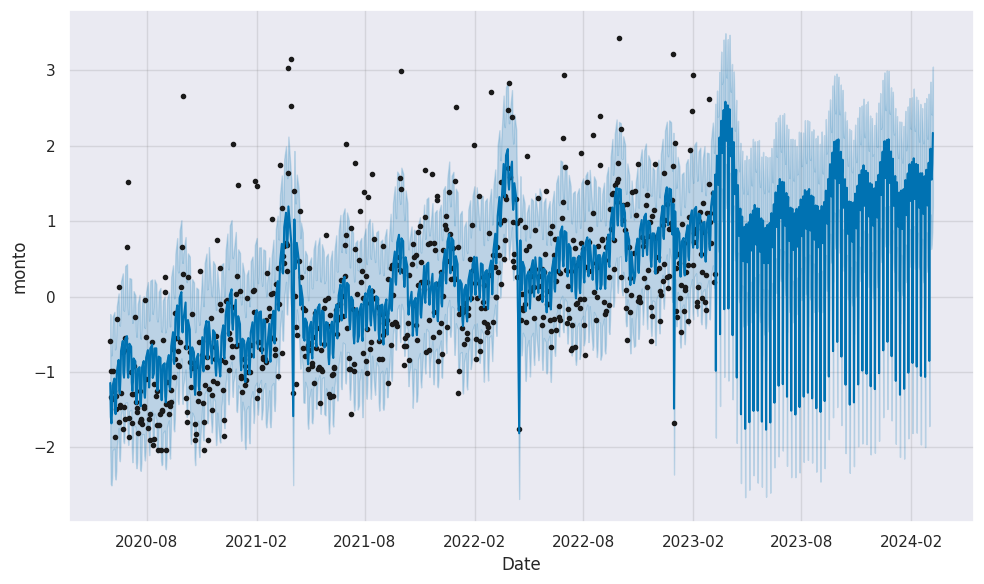

In [241]:
figure = m.plot(forecast, xlabel='Date', ylabel='monto')

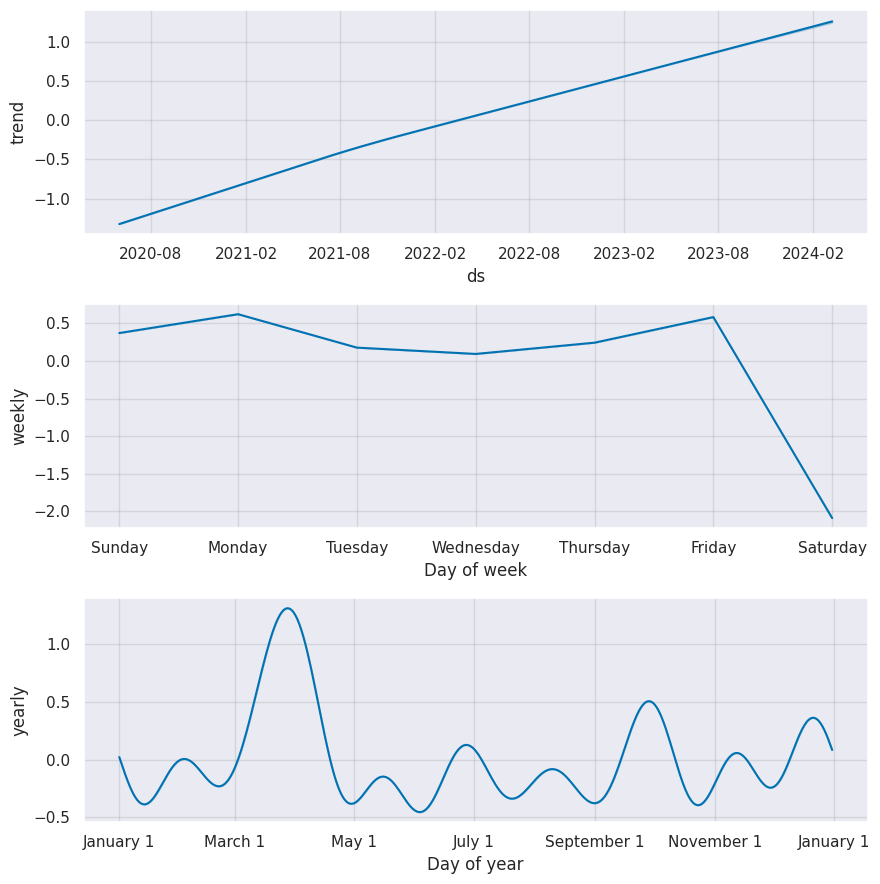

In [242]:
figure3 = m.plot_components(forecast)